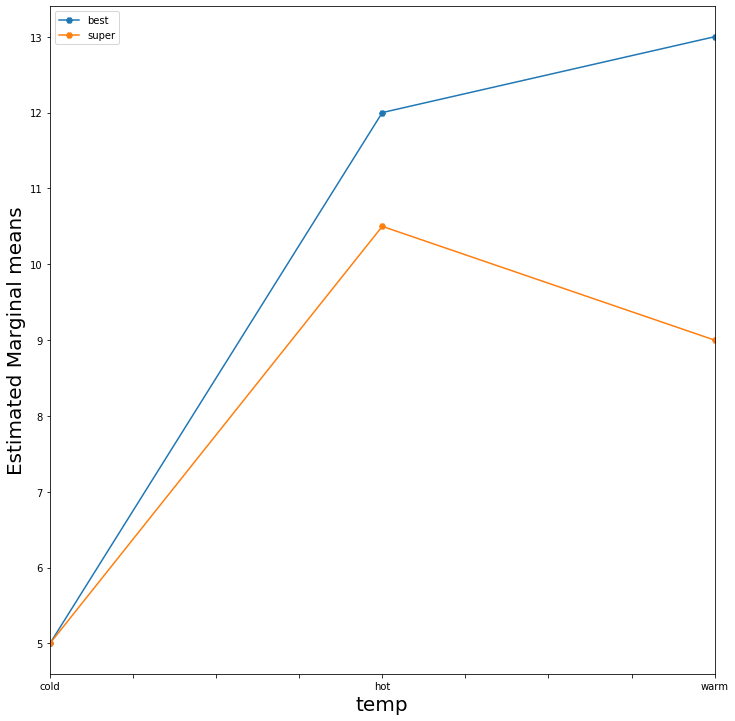

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from openpyxl import styles, load_workbook
import os
import jinja2
import pdfkit

# `Nan` value removal for DataFrame
def remnan(df, fill='--'):
    indexdict = {}
    for x in df.values:
        for i,x1 in enumerate(x,0):
            if i not in indexdict.keys():
                if x1 != fill:
                    indexdict[i] = [round(x1,4)]
            else:
                if x1 != fill:
                    indexdict[i].append(round(x1,4))
    order_list = list(indexdict.keys())
    order_list.sort()
    indexdict2= {}
    for num2 in order_list:
        indexdict2[num2] = indexdict[num2]
    dt = pd.DataFrame(columns=df.columns)
    for cols,ent in zip(df.columns,indexdict2.values()):
        dt.loc[:, cols] =ent
    dt.index = range(1,len(dt)+1)
    return dt

class reportcreate:

    def __init__(self, header='Main Title', blocks={}):
        pass
        

def anovarun(file='data.csv'):
    """
    Docstring: Function generates runs an Anova 2 ways analysis from a csv file

    """
    # Convert csv data to `pandas.DataFrame` [df2]
    ddf2 = pd.read_csv(file, header=0, sep=',')
    ddf2.index = range(1, len(ddf2)+1) # Renumber [df2]

    fcols = list(ddf2.columns)[0:2] # factor columns for DataFrame
    vcols = list(ddf2.columns)[2] # value columns for DataFrame

    # Pivot table based on the 1st and 2nd factors
    df2_pivot = ddf2.pivot_table(columns=fcols, values=vcols, index=ddf2.index, fill_value='--')

    df2_pivot = remnan(df2_pivot) # Removes nan values from [df2_pivot]
    dm = df2_pivot.melt(value_name=vcols) # Melt table back to original [dm]
    dmgr = dm.groupby(fcols).mean() # Grouping Melted table and calculating mean [dmgr]
    dmgr_unstack = dmgr.unstack(1) # unstacking data of 1st factor on index

    # Calculation of mean values
    dmgr_unstack_mean = dmgr_unstack.copy() # DataFrame copy to [dmgr_unstack_mean]
    dmgr_unstack_mean.loc[:,(vcols,'Average')] = dmgr_unstack_mean.apply(lambda x: round(np.mean(x),1), axis=1) # calculating mean of values along row as [['Average']]
    dmgr_unstack_mean.loc['Average',:] = dmgr_unstack_mean.apply(np.mean, axis=0) # calculating mean of values along column on index [['Average']]

    # Sum of Square of 1st factor
    nv = len(df2_pivot.columns) * 2 # finding number of data for 1st factors [nv]
    m1v = dmgr_unstack_mean.iloc[0,3] # Mean of first category on first factor
    m2v = dmgr_unstack_mean.iloc[1,3] # Mean of first category on second factor
    xv = dmgr_unstack_mean.iloc[2,3] # Data overall mean
    ss1v = round(nv*(m1v-xv)**2+nv*(m2v-xv)**2, 4) # Mathematical calculation for [ss1v]

    # Sum of Square of 2nd factor
    n1 = len(df2_pivot.index) # finding number of data for 2nt factors [n1]
    nps = dmgr_unstack_mean.iloc[-1,:].values[0:3]
    sum1 = 0
    ## Loop to solve [ss2v]
    for nums in np.nditer(nps):
        sum1 = sum1 + n1*(nums - xv)**2
    ss2v = round(2 * sum1,4)

    # Sum of Square within (Error)
    df2_pivot_ssw = df2_pivot.copy() # Copy [df2_pivot] to [df2_pivot_ssw]
    
    ## function to perform iteration on apply method [df2_pivot_ssw]
    def sswdo(arg,x):
        li1 = []
        arg = arg.values
        for num2,xi in zip(arg,x):
            li1.append((num2-xi)**2)
        return sum(li1)
    li2 = list(dmgr_unstack_mean.iloc[0,0:3].values)+list(dmgr_unstack_mean.iloc[1,0:3].values)
    ssw = sum(df2_pivot_ssw.apply(sswdo, x=li2, axis=1))

    # Sum of Square Total
    sst = round(dm.result.apply(lambda x: (x-xv)**2).sum(),2) # (x-xv)**2: for sum of square total [sst]

    # Sum of square for both factors [ssb]
    ssb = round(sst-ss1v-ss2v-ssw,2)

    # Degree of Freedom calcution
    df1 = len(dmgr_unstack_mean.index)-2 # degree of freedom for factor 1
    df2 = len(dmgr_unstack_mean.columns)-2 # degree of freedom for factor 2
    dfw = (len(df2_pivot)-1)*len(df2_pivot.columns) # degree of freedom for within
    dfb = df1 *df2 # degree of freedom for both
    dft = df1+df2+dfw+dfb # degree of freedon both

    # Create Anova table
    anova = pd.DataFrame(columns=['SS','df','mean_sum','F'], index=[df2_pivot.columns.names[0],df2_pivot.columns.names[1],df2_pivot.columns.names[0]+':'+df2_pivot.columns.names[1],'Residual','total'])
    anova.index.name = 'Sources'
    
    # Fill Anova table
    anova.loc[df2_pivot.columns.names[0],:] = [ss1v,df1,round(ss1v/df1,2),round((ss1v/df1)/(ssw/dfw),2)]
    anova.loc[df2_pivot.columns.names[1],:] = [ss2v,df2,round(ss2v/df2,2),round((ss2v/df2)/(ssw/dfw),2)]
    anova.loc[df2_pivot.columns.names[0]+':'+df2_pivot.columns.names[1],:] = [ssb,df1,round(ssb/dfb,2),round((ssb/dfb)/(ssw/dfw),2)]
    anova.loc['Residual',:] = [ssw,dfw,round(ssw/dfw,2),'']
    anova.loc['total',:] = [sst,dft,'','']

    # Profile plot preparation
    li4 = []
    for nums1,li3 in zip(range(1,len(df2_pivot.columns)+1),df2_pivot.columns):
        if nums1==1:
            li4.append(li3[0])
        elif nums1==(len(df2_pivot.columns)/2)+1:
            li4.append(li3[0])
    fig0 = plt.figure(2,figsize=(10,10))
    ax = plt.subplot(111, label='Axes 1')
    dmgr_unstack_plt = dmgr.unstack(0)
    dmgr_unstack_plt.plot(ax=ax, marker='H')
    plt.legend(li4)
    plt.tight_layout()
    ax.set_ylabel(ylabel='Estimated Marginal means', fontdict={'size':20})
    ax.set_xlabel(xlabel=ax.get_xlabel(), fontdict={'size':20})
    fig0.savefig('plot.png',format='png', bbox_inches='tight')
    plt.show()

    # Report creation into Pdf
    filename = "ereport.xlsx"
    anova.to_excel(filename, sheet_name='Table')
    wb = load_workbook(filename)
    ws = wb.worksheets[0]

    # Setting up border styles
    bleftv = styles.Side(style='thin')
    brightv = styles.Side(style='thin')
    btopv = styles.Side(style='thin')
    bbottomv = styles.Side(style='thin')
    borderv = styles.borders.Border(bleftv,brightv,btopv,bbottomv)
    for cols_cells in ws.columns:
        length = max(len(str(cell.value)) for cell in cols_cells) + 5
        ws.column_dimensions[cols_cells[0].column_letter].width = length
        for cell in cols_cells:
            cell.border = borderv
    wb.save(filename)
    wb.close()
    command = f'explorer {filename}'
    #os.system(f'cmd /c {command}')
    
    # Generating report to html
    def spacefact(df):
        max1 = 0
        for idf,rows in df.iterrows():
            n_len = len(str(idf))
            if n_len > max1:
                max1 = n_len
        return max1
    templateLoader = jinja2.FileSystemLoader(searchpath="./")
    templateEnv = jinja2.Environment(loader=templateLoader, extensions=['jinja2.ext.do'])
    TEMPLATE_FILE = "template.jinja"
    template = templateEnv.get_template(TEMPLATE_FILE)
    outputText = template.render(ddf2=ddf2,df=df2_pivot, df2=dmgr_unstack_mean, ano=anova,zip=zip, list=list, len=len, space=spacefact)
    html_file = open('report1.html', 'w')
    html_file.write(outputText)
    html_file.close()
    
    # Converting Html report to pdf
    path_wkhtmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
    config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)
    pdfkit.from_file('report1.html', 'report1.pdf', configuration=config)

    return df2_pivot,dmgr_unstack_mean,fig0,anova,ddf2

if __name__ == "__main__":
    df2_pivot,dmgr_unstack_mean,fig0,anova,ddf2 = anovarun()

In [24]:
import jinja2

In [25]:
img = 'plot.png'

In [26]:
def spacefact(df):
    max1 = 0
    for idf,rows in df.iterrows():
        n_len = len(str(idf))
        if n_len > max1:
            max1 = n_len
    return max1

In [42]:
templateLoader = jinja2.FileSystemLoader(searchpath="./")
templateEnv = jinja2.Environment(loader=templateLoader, extensions=['jinja2.ext.do'])
TEMPLATE_FILE = "template.jinja"
template = templateEnv.get_template(TEMPLATE_FILE)
outputText = template.render(ddf2=ddf2,df=df2_pivot, df2=dmgr_unstack_mean, ano=anova,zip=zip, list=list, len=len, space=spacefact)
html_file = open('report1.html', 'w')
html_file.write(outputText)
html_file.close()

In [44]:
import pdfkit

In [45]:
path_wkhtmltopdf = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)
pdfkit.from_file('report1.html', 'report1.pdf', configuration=config)

In [75]:
gg = pd.DataFrame([[1,2,3,1,2,3],[3,4,1,4,2,3],[2,np.nan,np.nan,3,3,4]])

In [76]:
gg.columns = (('two',0),('two',1),('two',2),('three',0),('three',1),('three',2))

In [62]:
gg.sort_values(by=1, inplace=True)

In [77]:
gg

two           three      
    0    1    2     0  1  2
0   1  2.0  3.0     1  2  3
1   3  4.0  1.0     4  2  3
2   2  NaN  NaN     3  3  4

In [115]:
gg.loc[:,('two',0)].count()

3

In [109]:
def catall(df):
    li5=[]
    li7=[]
    for nums1,li6 in zip(range(1,len(df.columns)+1),df.columns):
        if nums1==1:
            li5.append(li6[0])
        elif nums1==(len(df2_pivot.columns)/2)+1:
            li5.append(li6[0])
    for cat in li5:
        li7.append(sum(df.loc[:,cat].count()))
    return li7

In [110]:
catall(gg)

[7, 9]

In [134]:
xv = 3
sum1 = 0
for cc in ['two','three']:
    ins = gg.loc[:,(cc)].count().values
    for n,nums in zip(ins,[2,3,4]):
        sum1 = sum1 + n*(nums - xv)**2
        print(sum1)

3
3
5
8
8
11


In [119]:
for n in gg.loc[:,('two')].count().values:
    print(n)

3
2
2


In [126]:
sum1

10

In [176]:
gg

two           three      
    0    1    2     0  1  2
0   1  2.0  3.0     1  2  3
1   3  4.0  1.0     4  2  3
2   2  NaN  NaN     3  3  4

In [136]:
k = [0,5,9, 0]

In [138]:
'GGGG'.upper()

'GGGG'

In [153]:
list(gg.iteritems())[0][1].count()

3

In [175]:
for v in gg.iteritems():
    v[1].count()

3 

2 

2 

3 

3 

3 



In [196]:
j = [5,6,7,2,3,3]
chk = int(len(j)/len([2,3]))
index = 0
emptylist = []
for m in [2,3]:
    for m2 in range(index, chk+index):
        emptylist.append((m,j[m2]))
    index = m2+1

In [197]:
emptylist

[(2, 5), (2, 6), (2, 7), (3, 2), (3, 3), (3, 3)]

In [229]:
def round4(num):
    string = str(round(num,4))
    cut = string.index('.')
    first_string = string[0:cut]
    sub_string = string[cut:]
    lent = len(sub_string)
    print(lent,sub_string)
    if lent < 5:
        outfloat = first_string+sub_string+'0'*(5-lent)
        print('run')
    else:
        outfloat = first_string+sub_string
    return outfloat
        

In [231]:
round4(3.4)

2 .4
run


'3.4000'

In [215]:
g = '%.4f'% (4.666)

In [216]:
float(g)

4.666

In [232]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
df_anova2 = pd.read_csv("https://raw.githubusercontent.com/Opensourcefordatascience/Data-sets/master/crop_yield.csv")
model = ols('Yield ~ C(Fert)*C(Water)', df_anova2).fit()
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
res = sm.stats.anova_lm(model, typ= 2)
res

Overall model F( 3, 16) =  4.112, p =  0.0243


,sum_sq,df,F,PR(>F)
C(Fert),69.192,1.0,5.766000,0.028847
C(Water),63.368,1.0,5.280667,0.035386
C(Fert):C(Water),15.488,1.0,1.290667,0.272656
Residual,192.000,16.0,NaN,NaN
